In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import datetime

## Definición de funciones para simulación

In [2]:
unif = np.random.default_rng().uniform
normal = np.random.default_rng().normal


# Simulación de matriz Normal con parámetros 0, sigma^2*I
def Normal_pp(p, sigma=1):
    A = np.array(normal(0, sigma, p**2)).reshape((p,p))
    return A

# Simulación matriz Wishart con parámetros p, sigma^2*I
def Wishart_pp(p, sigma=1):
    A = np.array(normal(0, sigma, p**2)).reshape((p,p))
    return A@A.T

# Función Gamma_p presente en la densidad del problema
def gamma_p(k, p):
    product = np.pi**(p*(p-1)/4)

    for i in range(p):
        product *= stats.gamma((k/2) - (i-1)/2).pdf(1)
    return product

# Densidad f Wishart
def f(X, k, V, invV):
    min_eigval = min(np.linalg.eigvals(X))
    if min_eigval< 1e-10:
        return 0
    
    p = V.shape[0]
    detX = np.linalg.det(X)
    detV = np.linalg.det(V)
    trace = np.trace(invV @ X)
    num = np.exp(-trace/2) * detX**((k-p-1)/2)
    denom = 2**(k*p/2) * (detV**(k/2)) * gamma_p(k,p)
    return num/denom

# Densidad f Wishart reducida a términos que no se cancelan
def reduced_f(X, k, V, invV):
    min_eigval = min(np.linalg.eigvals(X))
    if min_eigval < 1e-10:
        return 0
    
    p = V.shape[0]
    detX = np.linalg.det(X)
    trace = np.trace(invV@X)
    _ = np.exp(-trace/2) * detX**((k-p-1)/2)
    return _
    
# Rutina de simulación con Random Walk Metropolis Hastings
def simulate_Wishart(args):

    p = args["p"]
    r = args["r"]
    sigma_V = args["sigma_V"]
    sigma_Yt = args["sigma_Yt"]
    n = args["n"]

    print(f"Simulando {p}x{p}")

    start = datetime.datetime.now()

    k = p + r
    V = Wishart_pp(p, sigma_V)
    invV = np.linalg.inv(V)

    X0 = Wishart_pp(p, sigma_Yt)
    X_chain = np.zeros((n,p,p))
    X_chain[0] = X0

    for i in range(n - 1):
        Xt = X_chain[i]
        Zt = Normal_pp(p, sigma_Yt)
        Yt = Xt + (1/2)*(Zt + Zt.T)
        Ut = unif(0,1)
        a = np.min([1, reduced_f(Yt, k, V, invV)/reduced_f(Xt, k, V, invV)])

        if Ut < a:
            X_chain[i + 1] = Yt
        else:
            X_chain[i + 1] = Xt
    end = datetime.datetime.now()
    file = open(f"./dataP1/file_{str(p).zfill(2)}.obj", "wb")
    pickle.dump((V, X_chain, (end-start).seconds), file)
    file.close()
    print(f"Terminado {p}x{p}")

### Primeros tests

In [149]:
sigma_V = 2
sigma_Yt = 10
n = 1_000_000
r = 3.5
p = 3

V = Wishart_pp(p, sigma_V)

X_chain = simulate_Wishart({"p" : p, "r" : r, "sigma_Yt" : sigma_Yt, "sigma_V" : sigma_V, "n" : n})
X_trim = X_chain[n//100:,:,:]
X_mean = X_trim.mean(axis=0)

### Graficos y análisis de resultados

Lectura de datos

In [267]:
p = 2
r = 3.5
k = p + r
file = open(f"./dataP1/file_{str(p).zfill(2)}.obj", "rb")
(V, X_chain, time) = pickle.load(file)
file.close()


Grafico variabilidad de la traza en el experimento

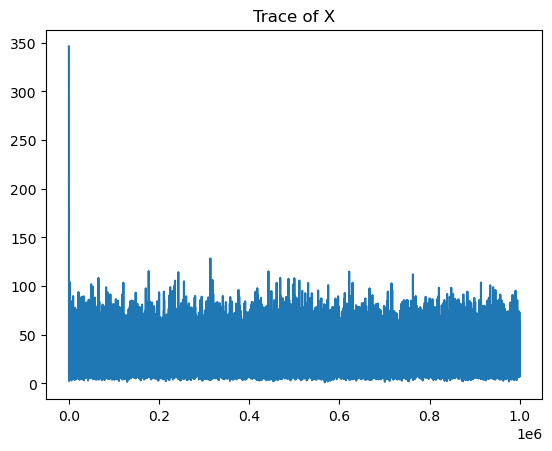

In [281]:
n = X_chain.shape[0]
x = range(1, n+1)
y = X_chain.trace(axis1 = 1, axis2 = 2)

fig, ax = plt.subplots()
ax.plot(x, y)
plt.title("Trace of X")
plt.show()

Normalización por valor propio maximo

In [286]:
X_reduced = X_chain[10000:,:,:]
maxeigvals = np.max(np.linalg.eigvals(X_reduced),axis=1)
maxeigval = maxeigvals.max()

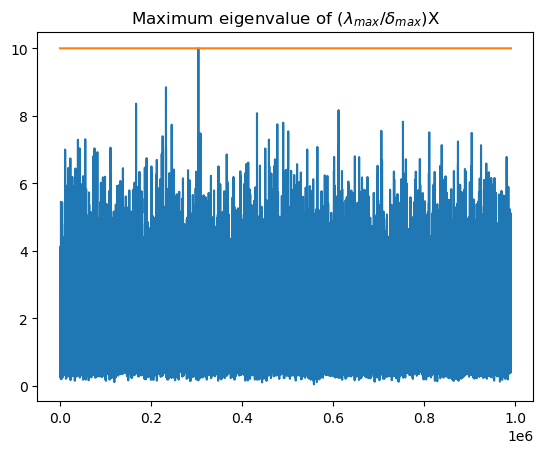

In [296]:
n = X_reduced.shape[0]
x = range(1, n+1)
maxl = 10
y = (maxl/maxeigval)*maxeigvals

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x,np.repeat(10,n))
plt.title("Maximum eigenvalue of $(\lambda_{max}/\delta_{max})$X")
plt.show()

Calculo de esperanza muestral

In [268]:
print(f"{X_chain[100000:,:,:].mean(axis=0)}")

[[16.00933656  5.2866574 ]
 [ 5.2866574  12.0453995 ]]


Cálculo de esperanza teórica

In [269]:
print(k * V)

[[15.03459905  4.7962837 ]
 [ 4.7962837  11.42696995]]


Cálculo de Varianza muestral

In [263]:
print(f"{X_chain[100000:,:,:].var(axis = 0)}")

[[92.57132584 39.84922439]
 [39.84922439 52.396976  ]]


Cálculo de varianza teórica

In [264]:
A = np.multiply(V, V)
B = np.multiply(np.tile(V.diagonal(),(V.shape[0],1)), np.tile(V.diagonal(),(V.shape[0],1)).T)

print(k * (A + B))

[[82.1960613  35.41895433]
 [35.41895433 47.48205168]]


Histograma de valores en la diagonal

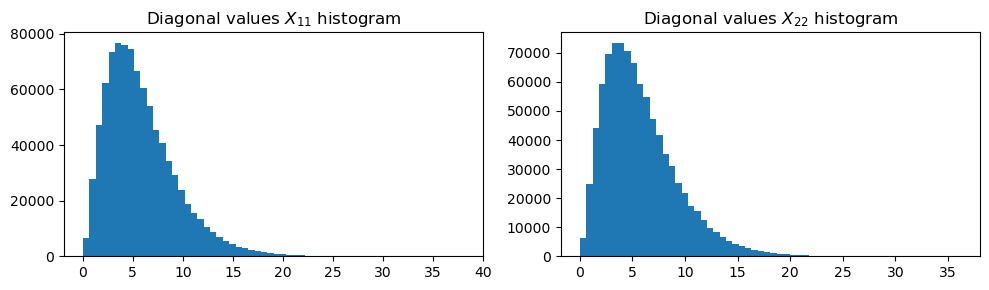

In [275]:
X11 = X_chain[100000:,0,0]
v11 = V[0,0]
X22 = X_chain[100000:,1,1]
v22 = V[1,1]

fig, axes = plt.subplots(1,2,figsize=(10,3))

axes[0].set_title("Diagonal values $X_{11}$ histogram")
axes[0].hist(X11/v11, bins=60, )
axes[1].set_title("Diagonal values $X_{22}$ histogram")
axes[1].hist(X22/v22, bins=60)

plt.tight_layout()
plt.show()

Test de kolmogorov Smirnov para verificar distribución chi cuadrado de la diagonal

In [254]:
stats.kstest(X11/v11, stats.chi2(df=k).cdf)

KstestResult(statistic=0.04094233751150789, pvalue=0.0, statistic_location=5.60008307312919, statistic_sign=-1)

### Visualizaciones para informe

In [256]:
p_max = 10
p_range = range(2, p_max + 1)
df_trace = pd.DataFrame(columns=[str(x) for x in p_range])
df_determinant = pd.DataFrame(columns=[str(x) for x in p_range])
df_maxeigval = pd.DataFrame(columns=[str(x) for x in p_range])
times = []
V_array = []

for i in p_range:
    file = open(f"./dataP1/file_{str(i).zfill(2)}.obj", "rb")
    (V, X_chain, time) = pickle.load(file)
    file.close()

    df_trace[str(i)] = X_chain.trace(axis1 = 1, axis2 = 2)
    df_determinant[str(i)] = np.linalg.det(X_chain)
    df_maxeigval[str(i)] = np.max(np.linalg.eigvals(X_chain),axis=1)
    times.append(time)
    V_array.append(V)
    

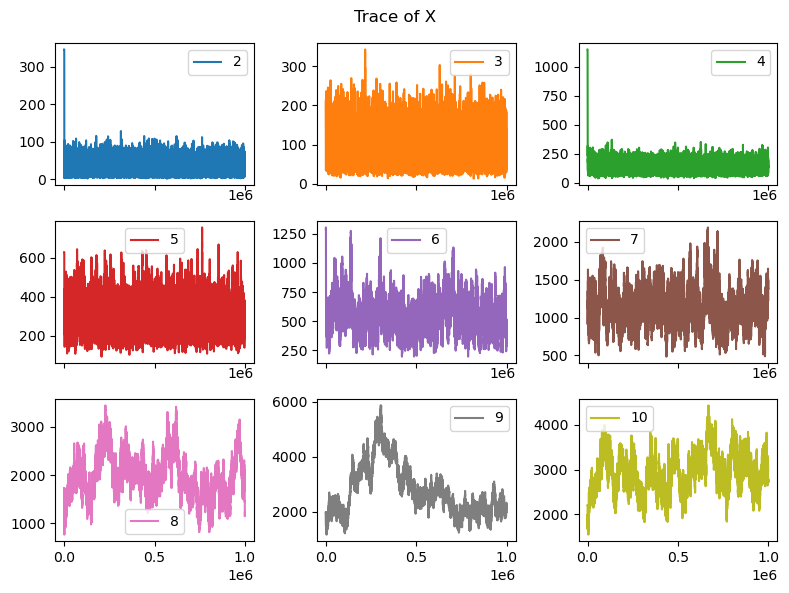

In [257]:
df_trace.plot(subplots=True, figsize=(8,6), layout=(3,3), sharex=True, title="Trace of X")

plt.tight_layout()
plt.show()

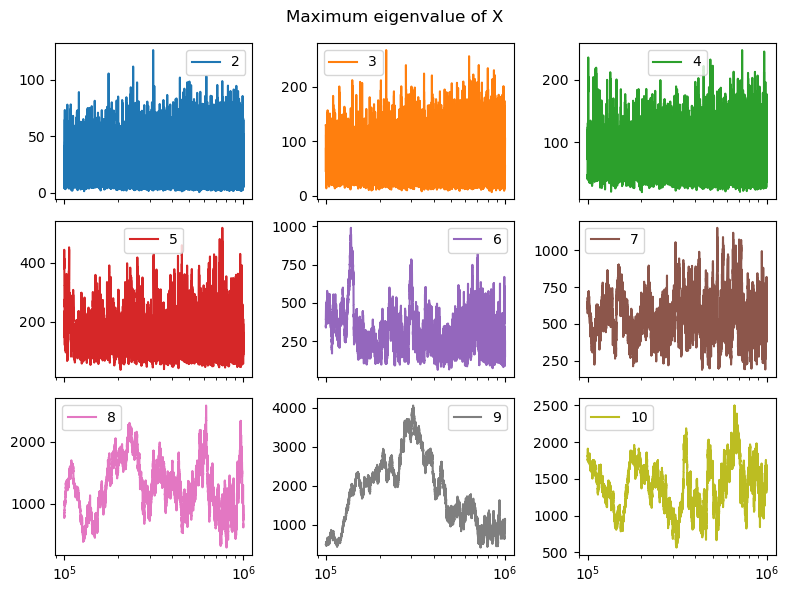

In [258]:
df_maxeigval.iloc[100_000:,:].plot(subplots=True, figsize=(8,6), layout=(3,3), sharex=True, title="Maximum eigenvalue of X", logx=True)

plt.tight_layout()
plt.show()

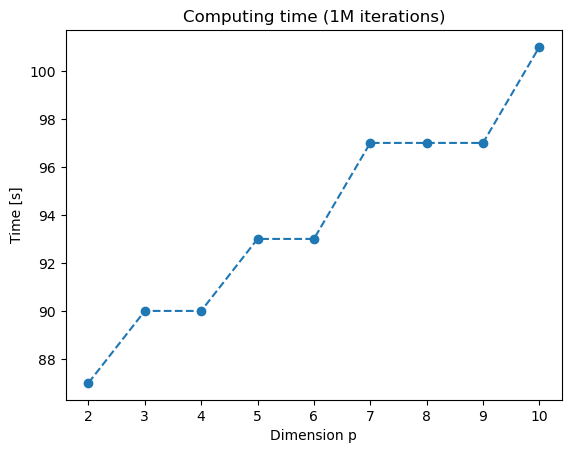

In [276]:
fig, axes = plt.subplots()
axes.plot(p_range, times, linestyle="--", marker="o")
axes.set_title("Computing time (1M iterations)")
axes.set_xlabel("Dimension p")
axes.set_ylabel("Time [s]")
plt.xticks(p_range)

plt.show()